## PBMC 3k的scanpy标准流程
参考：https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html

## 读取数据
数据已在`/data/pbmc3k`中呈现，若要下载数据，可在`./bash`目录中运行：
```bash
chmod +x pbmc_download.sh
bash ./pbmc_download.sh
```

## 数据读取和预处理

In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [3]:
## 预设置
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

/var/folders/s8/0mvfbk_j3_7chd0wj4khg3bh0000gn/T/ipykernel_63602/581042798.py:4: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


Component,Info
Python,"3.10.18 | packaged by conda-forge | (main, Jun 4 2025, 14:46:00) [Clang 18.1.8 ]"
OS,macOS-15.5-arm64-arm-64bit
CPU,"10 logical CPU cores, arm"
GPU,No GPU found
Updated,2025-08-08 16:16
Dependency,Version
joblib,1.5.1
h5py,3.14.0
six,1.17.0
decorator,5.2.1


In [4]:
## 设置结果保存的路径
result_file = "./pbmc_result"

In [5]:
## 读取10x数据
adata = sc.read_10x_mtx(
    "../data/pbmc3k/filtered_gene_bc_matrices/hg19/",
    var_names="gene_symbols",
    cache=True,
)

... reading from cache file cache/..-data-pbmc3k-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## preprocessing
### 质控

normalizing counts per cell
    finished (0:00:00)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


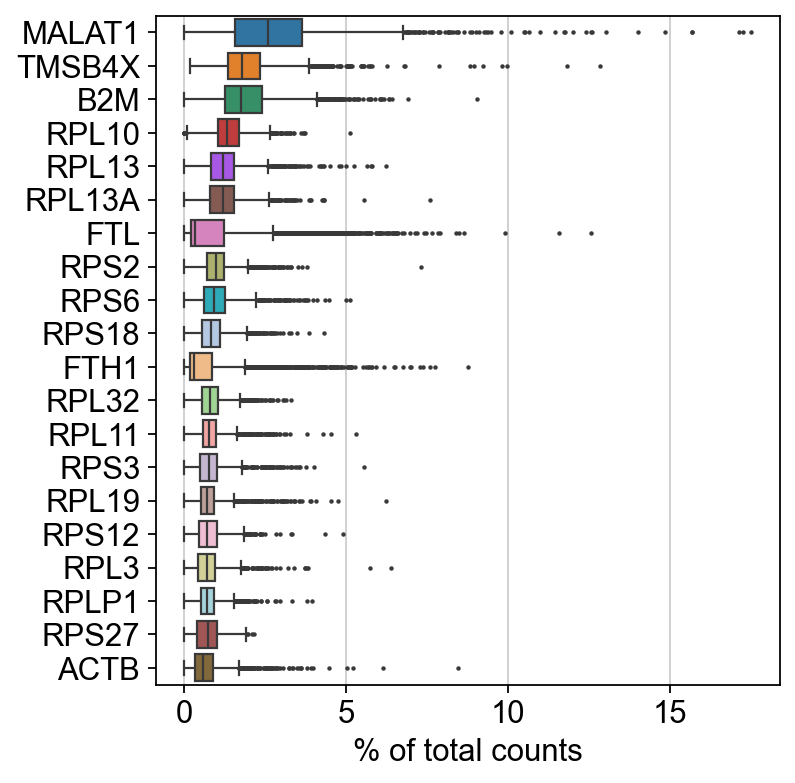

In [9]:
## 可视化数据集中表达量最高的前n个基因在所有细胞中的表达分布
sc.pl.highest_expr_genes(adata, n_top=20)

发现有很多RPL开头的基因，这些基因需要质控

In [8]:
## 常规质控
sc.pp.filter_cells(adata, min_genes = 200) # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells = 3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [9]:
## 计算线粒体基因占比
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


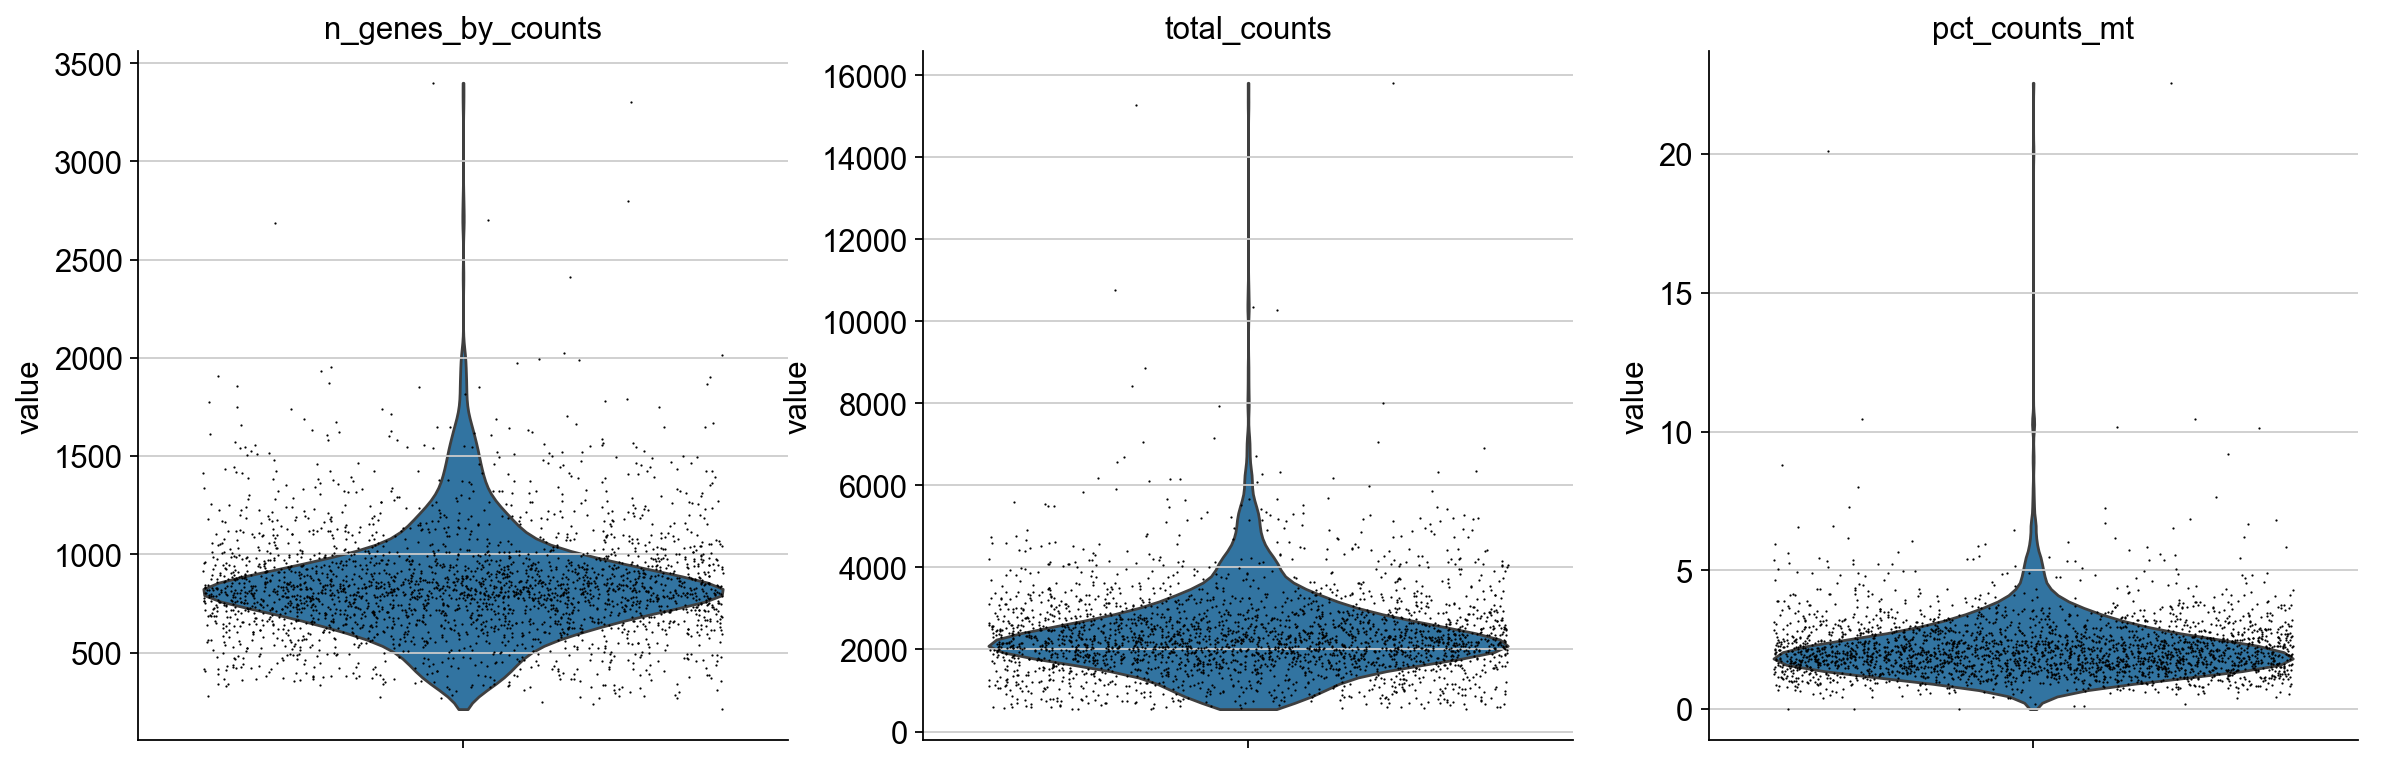

In [13]:
## 小提琴图可视化base qc metrics分布
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

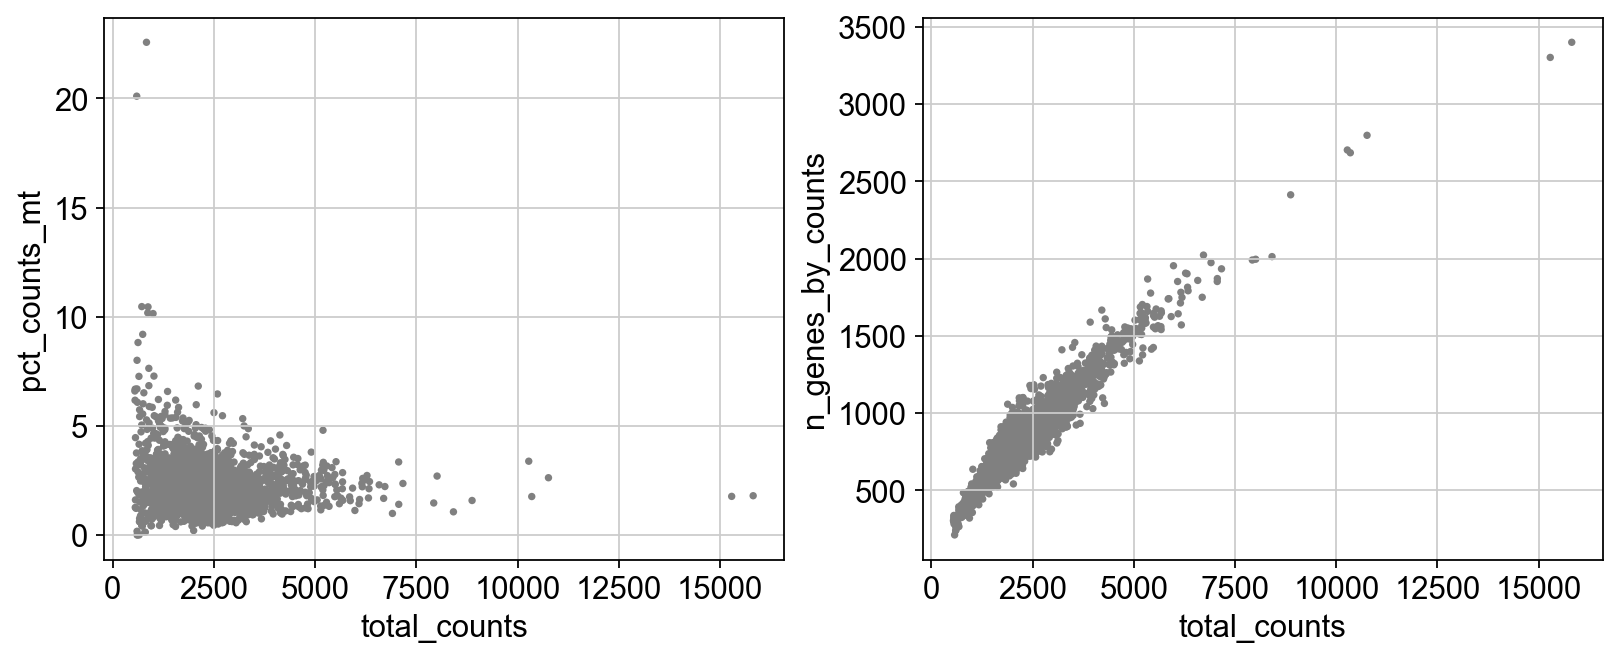

In [14]:
## 散点图可视化qc metrics分布
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

In [10]:
## 过滤
adata = adata[
    (adata.obs.n_genes_by_counts < 25000) &
    (adata.obs.n_genes_by_counts > 200) &
    (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 2643 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

### normalization标准化

In [11]:
## 把所有细胞的library size统一到10000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [12]:
## 取log(1+x)
sc.pp.log1p(adata)

### 特征选择
这里与Seurat的流程对接上

In [13]:
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


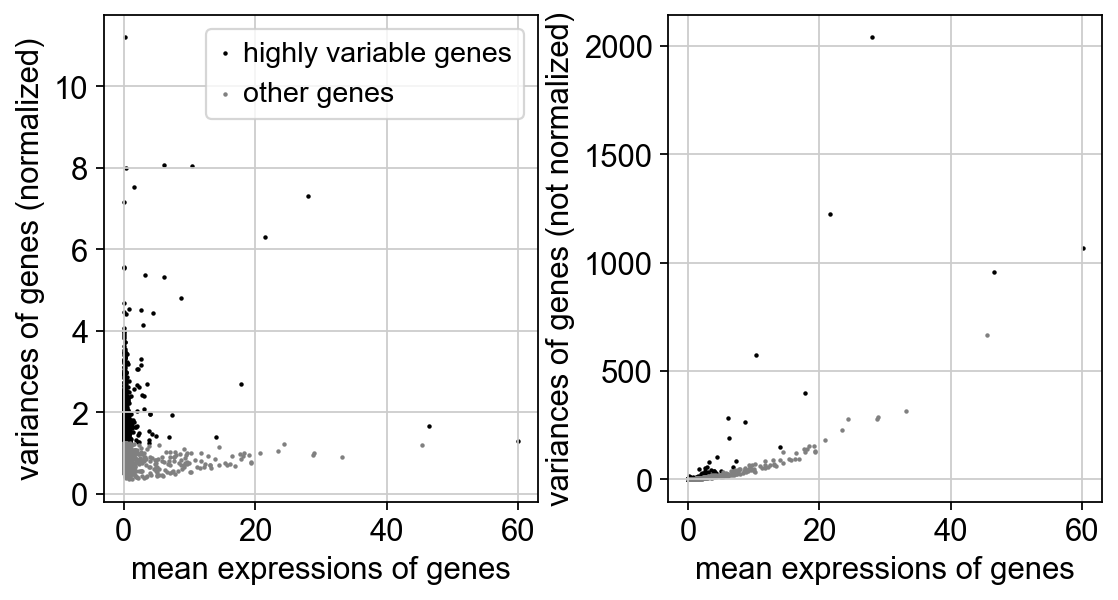

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
## 归一化
adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

regressing out ['total_counts', 'pct_counts_mt']


/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


    finished (0:00:01)


## PCA降维

In [16]:
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


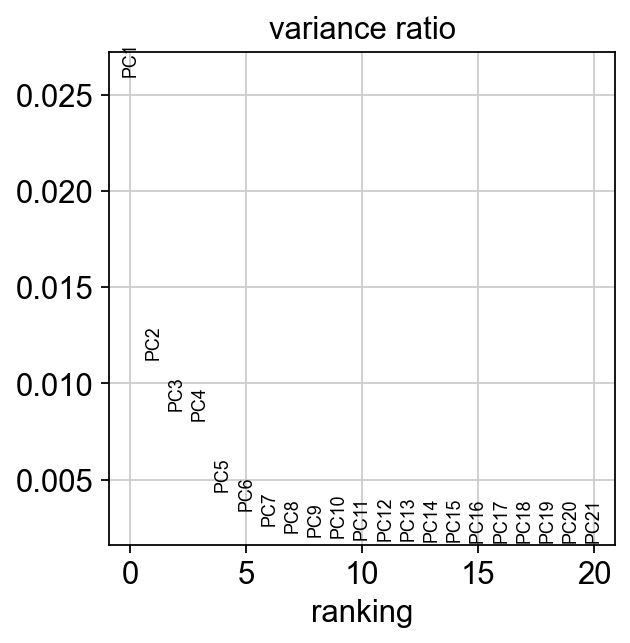

In [17]:
## elbow plot来选择合适的pcs
sc.pl.pca_variance_ratio(adata, n_pcs=20)

/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


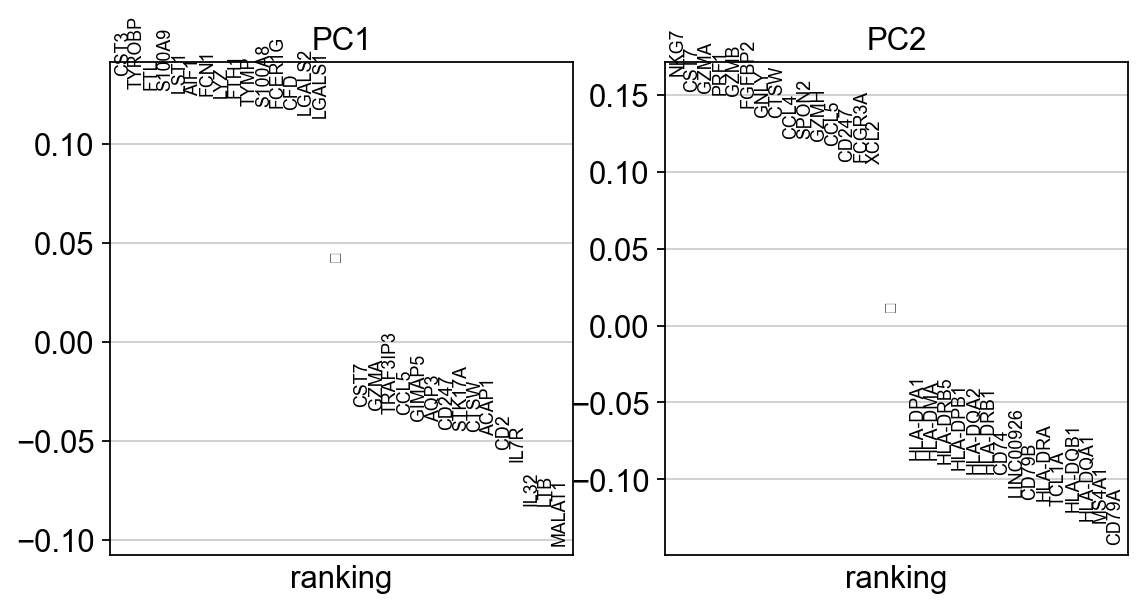

In [18]:
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

## 聚类

In [19]:
## 取top 40的主成分进行聚类
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/opt/anaconda3/envs/scepy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [21]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


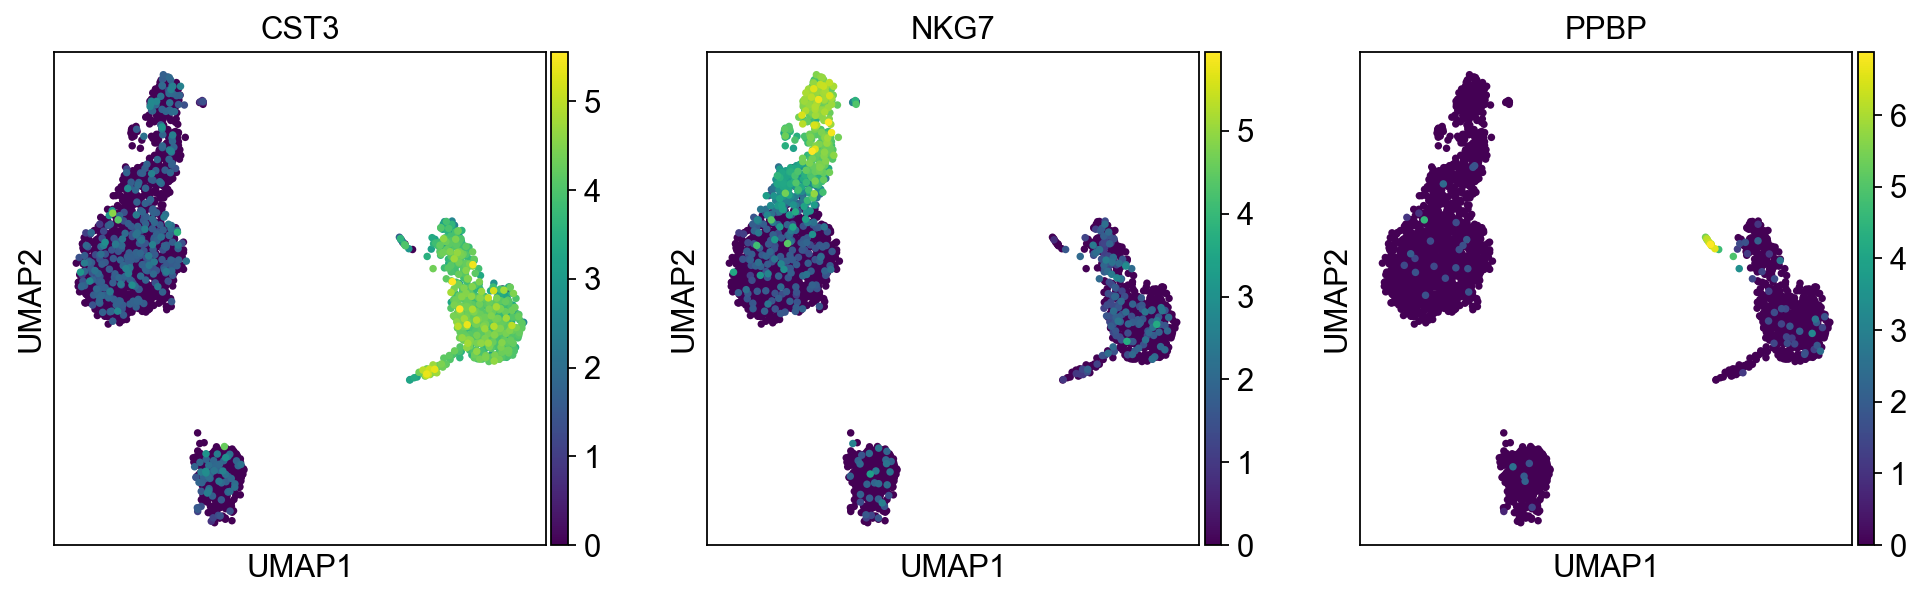

In [ ]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"]) ## 此时的adata.X是标准化后的counts

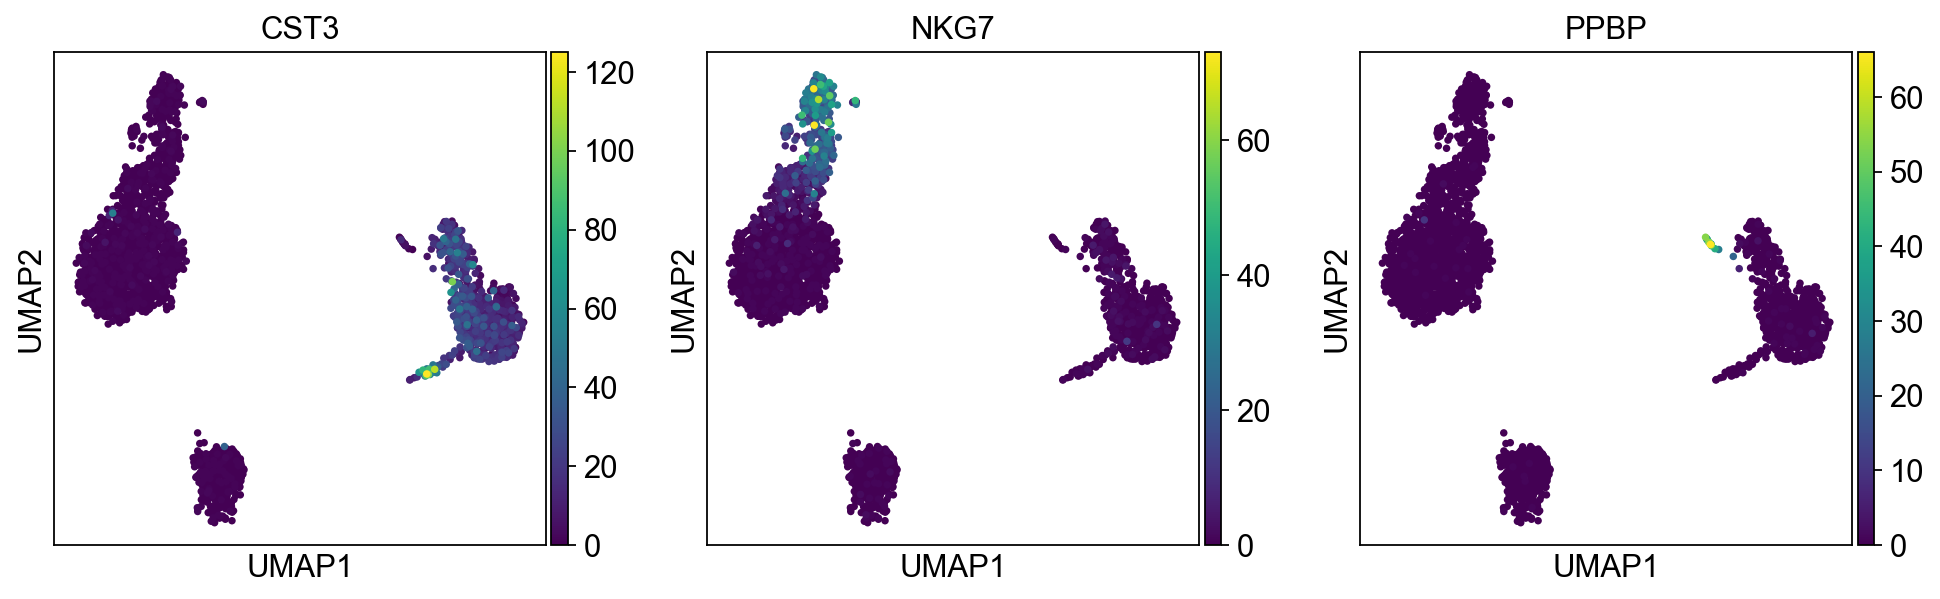

In [23]:
## 可以指定layer来可视化不同数据类型的表达情况
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="counts")

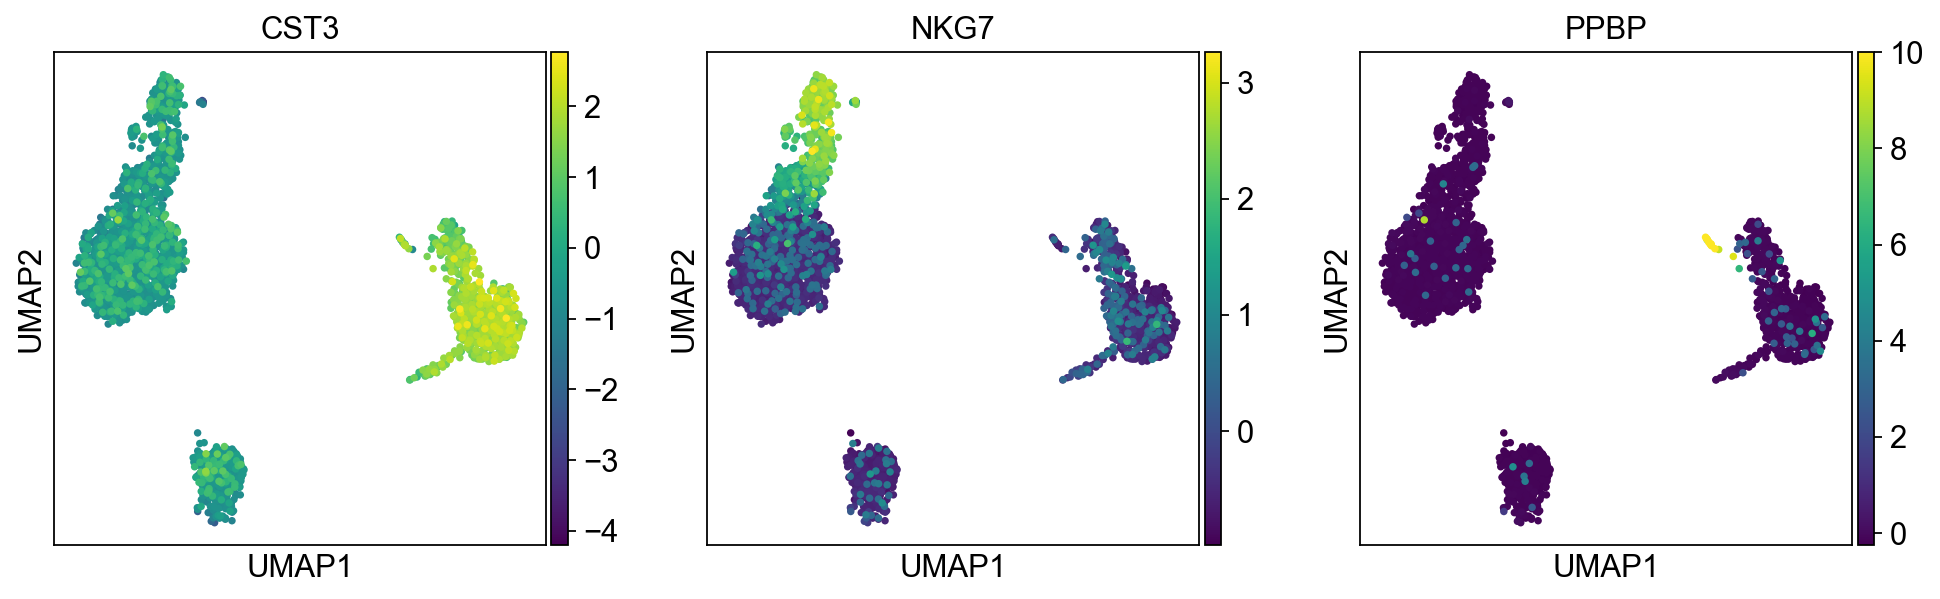

In [24]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="scaled")